In [2]:
import pandas as pd
import numpy as np

#визуал
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
%matplotlib inline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# для работы с адресами
from geopy.geocoders import Nominatim
#для работы с системными файлами
import os
#для работы с регулярными выражениями
import re
# парсинга
from bs4 import BeautifulSoup
import requests
# для работы с временем
import time

### Сбор данных

___

**Так как данные поступали в течени года и можно было с ними начать работать с самого начала проекта, было создано несколько функций для сбора всей информации в один датасэт**

In [3]:
DIRECTORY_fold = 'data/'

def get_list_all_files() -> list:
    """
    Returns:
        list: функция возвращает названия всех xlsx документов в нужном формате из папки data
    """
    
    ALL_FILES = []
    folds = os.listdir(DIRECTORY_fold)
    for fold in folds:
        DIRECTORY_file = DIRECTORY_fold + str(fold)
        files = os.listdir(DIRECTORY_file)
        files = os.listdir(DIRECTORY_file)
        ALL_FILES.extend(files)
    
    return ALL_FILES


def conversion(df):
    if len(df.columns) > 10:
        raise TypeError('Не подходящий формат')
    else:
        cols = df.columns[:8]
        df = df[cols]
        df['Unnamed: 3'] = df['Unnamed: 3'].apply(lambda x: np.nan if x == 'Наименование' else x)
        df.drop(df.columns[:2], axis=1, inplace=True)
        df.dropna(axis=0, inplace=True)
        df.set_index(np.arange(len(df.index)), inplace=True)

        #переименовываем столбцы
        df.rename(columns={'Unnamed: 2':'num', 'Unnamed: 3':'ration', 'Unnamed: 4':'address',
                        'Unnamed: 5':'start', 'Unnamed: 6':'finish',
                        'Unnamed: 7':'comment'}, inplace=True)

        # функция которая сокращает название рациона
        def edit_ration_name(name):
            if 'Снижение' in name:
                return name.replace('Снижение', '').strip()
            elif 'Баланс' in name:
                return name.replace('Баланс', '').strip()
            elif 'Classic' in name:
                return name.replace('Classic', '').strip()
            elif 'Набор' in name:
                return name.replace('Набор', '').strip()

        df['start'] = df['start'].apply(lambda x: int(x[0]) if len(x) <= 4 else int(x[:2])) # заменяем начало интервала со строкого формата на числовой
        df['finish'] = df['finish'].apply(lambda x: int(x[0]) if len(x) <= 4 else int(x[:2]))# заменяем конец интервала со строкого формата на числовой
        df['ration'] = df['ration'].apply(edit_ration_name)
    
        return df


def get_df(files: list) -> pd.DataFrame:
    """
    Args:
        files (list): Список названий файлов

    Returns:
        pd.DataFrame: датасэт из всех xlsx файлов в формате DataFrame
    """
    for i, file in enumerate(files):
        try:
            month = int(file.split('.')[1])
        except ValueError:
            print(file)
        if i == 0:
            data = pd.read_excel(f'data/{month}/{file}')
            data = conversion(data)
            data['date'] = [file.split('.')[:2]] * len(data)
            lenght = len(data)
        else:
            try:
                data_plus = pd.read_excel(f'data/{month}/{file}')
                data_plus = conversion(data_plus)
                data_plus['date'] = [file.split('.')[:2]] * len(data_plus)
                lenght += len(data_plus)
                data = pd.concat([data, data_plus], axis=0)
            except Exception:
                continue
    
    #data = data.drop(['Unnamed: 9'], axis=1)
    print(f'data shape is {data.shape[0]} should equal {lenght}')

    return data

Проверка формата каждого файла

In [4]:
flag_2 = True

if flag_2 is True:
    res = {}
    folds = os.listdir(DIRECTORY_fold)
    for fold in folds:
        DIRECTORY_file = DIRECTORY_fold + str(fold)
        files = os.listdir(DIRECTORY_file)
    
        ls = []
        for file in files:
            some_name = pd.read_excel(f'data/{fold}/{file}')
            finall = [file.split('.')[0], some_name.shape[1]]
            ls.append(finall)
        res[int(fold)] = ls

    for m, val in res.items():
        for elem in val:
            if elem[1] > 8:
                print(f'Month {m}')
                print(elem[0])

Month 8
29
Month 7
31
Month 4
09
Month 2
13


___

In [5]:
ALL_FILES = get_list_all_files()
df = get_df(ALL_FILES)

/tmp/ipykernel_13028/455618522.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Unnamed: 3'] = df['Unnamed: 3'].apply(lambda x: np.nan if x == 'Наименование' else x)
/tmp/ipykernel_13028/455618522.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df.columns[:2], axis=1, inplace=True)
/tmp/ipykernel_13028/455618522.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

data shape is 160180 should equal 160180


**was 160180**

### Преоброзование датасэта

___

In [6]:
df_test = df.copy(deep=True)

In [7]:
# Признак date преобразуем в формат datetime
df_test['date'] = df_test['date'].apply(lambda x: '/'.join(x) + '/2022')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y')

# Выделяем отдельные признаки месяца, дня месяца и дня недели
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['dow'] = df_test['date'].dt.day_of_week

In [8]:
# В ноябре названия некоторых пакетов поменялись, но сущность осталось таже. Поэтому переименовываем их обратно в старые, чтобы лучше ориентироваться
ration_new_dict = {
    '5 блюд 3 дня': 'M',
    '6 блюд 3 дня': 'L',
    '4 блюда 3 дня': 'S',
    '3 блюда 3 дня': 'XS',
    '5 блюд 2 дня': 'M (2)',
    '4 блюда 2 дня': 'S (2)',
    '6 блюд 2 дня': 'L (2)',
    '3 блюда 2 дня': 'XS (2)'
    }

df_test['ration'] = df_test['ration'].apply(lambda x: ration_new_dict[x] if x in ration_new_dict.keys() else x)

In [9]:
df_test = df_test.drop(['num', 'comment'], axis=1)
df_test.reset_index(inplace=True, drop=True)

In [10]:
def get_location(df: pd.DataFrame) -> list:
    """ Функция возвращает которкий адрес
        для улучшения поиска в библиотеке geopy

    Args:
        df (pd.DataFrame): Датафрейм с полными адресами включая квартиру, этаж и т.д

    Returns:
        list: Возвращает два списка: 
                                    1. C улицей и номером дома
                                    2. Населенный пункт
    """
    #список адресов
    list_of_address = df['address'].to_list()

    #созадем списки улицы, номера дома и города
    street_list, area_ekb_final = [], []
    
    #достаем названия улиц
    for elem in list_of_address:
        dig = re.findall(r'\d+', elem)
        ls = elem.split(',')
        if dig != []:
            result = [' '.join(ls[ind-1: ind + 1]) for ind, part in enumerate(ls) if dig[0] in part]
        else:
            result = 'not_detected'
        street_list.append(result)
    
    for ind, elem in enumerate(street_list):
        if elem == '':
            result = elem.split(',')[1:3]
            street_list[ind] = ' '.join(result)
    
    street_list = [elem[1].strip() if elem[0] == ' ' else elem[0].strip() for elem in street_list]
    street_list = [elem.replace('улица', 'ул').replace('проспект', 'пр-кт') for elem in street_list]
    
    #----------------------------------------------------------------
    # Достаем из полного адреса населенный пункт

    # Список крупных населенных пунктов
    area_ekb = [
    'Екатеринбург','Верхняя Пышма', 'Арамиль', 'Березовский', 'Ревда',
    'Среднеуральск', 'Полевской', 'Берёзовский', 'Заречный', 'Сысерть'
    ]

    # Проходимся по каждому адресу и достаем населенный пункт.
    # Сначала идет проверка на крупные наеленные пункты,
    # затем остается проверка на небольшие деревни и села.
    for elem in list_of_address:
        elem_list = [val.strip() for val in elem.split(',')]
        elem_set = set(elem_list)
        result = elem_set.intersection(area_ekb)
        if result == set():
            result = re.findall(r'снт \w+,', elem.lower())
            if result == []:
                result = re.findall(r'поселок \w+,', elem.lower())
                if result == []:
                    result = re.findall(r'село \w+,', elem.lower())
                    if result == []:
                        result ='Екатеринбург'
                    
        area_ekb_final.append(''.join(result))


    return street_list, area_ekb_final

In [11]:
street_list, area_ekb_exp = get_location(df_test)

df_test['street'] = street_list
df_test['area'] = area_ekb_exp
df_test['short_address'] = df_test['area'] + ', ' + df_test['street']

In [12]:
df_test

,ration,address,start,finish,date,month,day,dow,street,area,short_address
0,3500,"Россия, Свердловская область, Екатеринбург, ко...",6,8,2022-08-02,8,2,1,Екатеринбург коллективный сад № 25 АО УЗТМ,Екатеринбург,"Екатеринбург, Екатеринбург коллективный сад №..."
1,2000,"Верхняя Пышма, ул Кривоусова, 16 , кв. 4, эт. ...",6,8,2022-08-02,8,2,1,ул Кривоусова 16,Верхняя Пышма,"Верхняя Пышма, ул Кривоусова 16"
2,2500,"Успенский проспект, 18, Верхняя Пышма, Свердло...",6,8,2022-08-02,8,2,1,Успенский пр-кт 18,Верхняя Пышма,"Верхняя Пышма, Успенский пр-кт 18"
3,750,"Верхняя Пышма, Успенский пр-кт, 91 , кв. 167, ...",6,8,2022-08-02,8,2,1,Успенский пр-кт 91,Верхняя Пышма,"Верхняя Пышма, Успенский пр-кт 91"
4,1500,"Свердловская область, городской округ Верхняя ...",6,8,2022-08-02,8,2,1,Васильковая ул 12,"село балтым,","село балтым,, Васильковая ул 12"
...,...,...,...,...,...,...,...,...,...,...,...
160175,2000,"Россия, Свердловская область, Екатеринбург, ми...",9,11,2022-11-28,11,28,0,ул Шаумяна 24,Екатеринбург,"Екатеринбург, ул Шаумяна 24"
160176,M,"улица Шаумяна, 24, микрорайон Юго-Западный, Ек...",10,12,2022-11-28,11,28,0,ул Шаумяна 24,Екатеринбург,"Екатеринбург, ул Шаумяна 24"
160177,M,"улица Шаумяна, 24, микрорайон Юго-Западный, Ек...",10,12,2022-11-28,11,28,0,ул Шаумяна 24,Екатеринбург,"Екатеринбург, ул Шаумяна 24"
160178,3500,"Екатеринбург, ул Шаумяна, 24 , кв. 82, эт. 10,...",10,12,2022-11-28,11,28,0,ул Шаумяна 24,Екатеринбург,"Екатеринбург, ул Шаумяна 24"


In [13]:
df_test.isnull().sum()

ration           1328
address             0
start               0
finish              0
date                0
month               0
day                 0
dow                 0
street              0
area                0
short_address       0
dtype: int64

**Каждому адресу присваеваем широту и долготу**

Чтобы присвоить каждому адресу координаты, я решил использовать библиотеку *geopy*. Но если напрямую использовать данную библиотеку через метод *apply*, то разметка геоданных займет около 18 часов. Это связанно из-за невозможности распараллеливать вычисления(разрешен 1 запрос в n-время) и из-за траты времени на обработку запроса в диапазоне от 1 до 2 секунд. 

Поэтому было принято решение создать словарь, где ключ был бы равен какому-то адресу, а значение - это геоданные данного адреса. Так обработанный запрос записывался бы в словарь и уже при новом запросе с похожим адресом обращался бы к нему.

In [14]:
# Данный словарь уже у нас записан, поэтому

#Создаем объект класса для Nominatim из библиотеки geopy
geolocator = Nominatim(user_agent='location')
#Загружаем наш словарь(он уже заполнен некторыми адресами)
dict_loc= np.load('secondary_data/dict_loc.npy', allow_pickle=True).item()
#Геоданные Екатеринбурга, если geopy не распознает наш адрес
ekb_loc = [56.838011, 60.597474]

def get_geolocation(st: str) -> list:
    """Функция возвращает координаты входного адреса

    Args:
        st (str): Адрес дома

    Returns:
        list: Список координат 
    """
    try:
        result = dict_loc[st]
    # Если нет данного адреса в словаре, то срабатывает исключение
    except KeyError:
        try:
            location = geolocator.geocode(st, timeout=None)
            dict_loc.setdefault(st, [location.latitude, location.longitude])
            result = dict_loc[st]
        # Если geocode не распознал адрес,
        # то срабатывает исключение и забиваются координаты Екатеринбурга
        except AttributeError:
            dict_loc.setdefault(st, ekb_loc)
            result = ekb_loc 
    
    return result

In [15]:
# Поставить True, если нужно запустить ячейку
# Данная ячейка дополняет наш словарь новыми адресами,
# Она была использована для первичного заполнения словаря, когда он был пуст
flag = True

if flag is True:
    #Показывает количесвто уникальных адресов с каждой итерацией
    dict_density = []
    # Условие при котором можно остановить цикл поиска уникальных ключей,
    # достаточное для разметки данных в адекватный промежуток времени
    CONDITION = df_test['short_address'].nunique() * 0.8

    # Для быстрого поиска уникальных адресов, решено разбить датасэт на выборки из 10 частей
    split_data = np.array_split(df_test, 10)

    
    while len(dict_loc) <= CONDITION:
        #Проход по всем выборкам происходит со смещением в середину.
        # Это сделано для того, чтобы как можно быстрее охватить новые адреса и включить их в словарь,
        # так как за год новые адреса(клиенты) появлялись постоянно, а старые могли уходить.
        for i in [0, 9, 1, 8, 2, 7, 3, 6, 4, 5]:
            # Чтобы не прочитывать всю выборку, решено взять лишь часть в размере 33% 
            var_data = split_data[i].sample(3000)
            var_data['loc'] = var_data['short_address'].apply(get_geolocation)
            dict_density.append(len(dict_loc))
        
        #Сохраняем наш словарь
        np.save('secondary_data/dict_loc.npy', dict_loc)
        print(f'Уникальных объектов: {dict_density[-1]}, За цикл прибавилось: {max(dict_density) - min(dict_density)}')

In [16]:
start = time.time()
df_test['location'] = df_test['short_address'].apply(get_geolocation)
end = time.time()
print(f'Обработка адресов заняло {int((end - start) / 60)} минут(-ы)')

Обработка адресов заняло 3 минут(-ы)


**В итоге вместо 18 часов, добавление координат занимает несколько минут**

In [17]:
location_list = df_test['location'].to_list()
df_test['latitude'] = [elem[0] for elem in location_list]
df_test['longitude'] = [elem[1] for elem in location_list]

**Можно привязать погоду к каждой дате, чтобы увидеть в будущем какие либо закономерности**

In [18]:
weather = pd.read_csv('secondary_data/weather.csv', sep=';')
weather.head()

,Местное время в Екатеринбурге,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
22.12.2022 11:00,-16.9,743.4,771.7,0.2,67,"Ветер, дующий с западо-юго-запада",2,NaN,NaN,"90 или более, но не 100%",...,"Перистые нитевидные, иногда когтевидные, не ра...",20.0,-21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22.12.2022 08:00,-18.8,743.2,771.7,1.1,73,"Ветер, дующий с запада",3,NaN,NaN,60%.,...,Перистые (часто в виде полос) и перисто-слоист...,10.0,-22.4,Осадков нет,12.0,NaN,NaN,Ровный слой сухого рассыпчатого снега покрывае...,25.0,NaN
22.12.2022 05:00,-18.9,742.1,770.5,0.6,73,"Ветер, дующий с запада",5,NaN,NaN,Облаков нет.,...,NaN,10.0,-22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22.12.2022 02:00,-18.6,741.5,769.9,1.3,73,"Ветер, дующий с запада",3,NaN,NaN,Облаков нет.,...,NaN,10.0,-22.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21.12.2022 23:00,-18.3,740.2,768.5,1.2,72,"Ветер, дующий с западо-северо-запада",4,NaN,NaN,70 – 80%.,...,"Перистые нитевидные, иногда когтевидные, не ра...",10.0,-22.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Нам нужна только температура из данной таблицы
date, forecast = weather['Местное время в Екатеринбурге'].index, weather['Местное время в Екатеринбурге'].values
weather = pd.DataFrame({'date': date, 'weather': forecast})
weather['date'] = pd.to_datetime(weather['date']).dt.date

#Групируем данные по дате и находим среднюю температуру
weather = weather.groupby('date', as_index=False).mean()
weather['date'] = pd.to_datetime(weather['date'])

In [20]:
# Добовляем нашу температуру к главной таблице
df_test = df_test.merge(weather, how='left')
df_test['weather'] = df_test['weather'].apply(int)
df_test.head()

,ration,address,start,finish,date,month,day,dow,street,area,short_address,location,latitude,longitude,weather
0,3500,"Россия, Свердловская область, Екатеринбург, ко...",6,8,2022-08-02,8,2,1,Екатеринбург коллективный сад № 25 АО УЗТМ,Екатеринбург,"Екатеринбург, Екатеринбург коллективный сад №...","[56.838011, 60.597474]",56.838011,60.597474,-12
1,2000,"Верхняя Пышма, ул Кривоусова, 16 , кв. 4, эт. ...",6,8,2022-08-02,8,2,1,ул Кривоусова 16,Верхняя Пышма,"Верхняя Пышма, ул Кривоусова 16","[56.97059285, 60.580205250000006]",56.970593,60.580205,-12
2,2500,"Успенский проспект, 18, Верхняя Пышма, Свердло...",6,8,2022-08-02,8,2,1,Успенский пр-кт 18,Верхняя Пышма,"Верхняя Пышма, Успенский пр-кт 18","[56.838011, 60.597474]",56.838011,60.597474,-12
3,750,"Верхняя Пышма, Успенский пр-кт, 91 , кв. 167, ...",6,8,2022-08-02,8,2,1,Успенский пр-кт 91,Верхняя Пышма,"Верхняя Пышма, Успенский пр-кт 91","[56.838011, 60.597474]",56.838011,60.597474,-12
4,1500,"Свердловская область, городской округ Верхняя ...",6,8,2022-08-02,8,2,1,Васильковая ул 12,"село балтым,","село балтым,, Васильковая ул 12","[56.838011, 60.597474]",56.838011,60.597474,-12


### Работа с пропусками

In [21]:
df_test.isnull().sum()

ration           1328
address             0
start               0
finish              0
date                0
month               0
day                 0
dow                 0
street              0
area                0
short_address       0
location            0
latitude            0
longitude           0
weather             0
dtype: int64

**В признаке *ration* отсутствуют данные для 1000 строк, заполних им.** 

**Также создадим несколько дополнительных признаков - это цена за каждый пакет и строковое значение месяца**

In [22]:
price_list ={
    '1500': 650, '1000': 600, '2000': 700, '750': 550, '2500': 770,
    'M': 610, 'L': 670, 'S': 550, '3500': 850, 'XS': 500, 'M (2)': 320, 'L (2)': 330,
    '1500 (1)': 330, '1000 (1)': 300, 'S (2)': 360, '2000 (1)': 350,
    '750 (1)': 280, 'XS (2)': 330, '2500 (1)': 390, '1200': 630,
    '3500 (1)': 430, '1800': 680, '2400': 750
    }

month_dict = {
    1:'Январь', 2:'Февраль', 3:'Март', 4:'Апрель',
    5:'Май', 6:'Июнь', 7:'Июль', 8:'Август',
    9:'Сентябрь', 10:'Октябрь', 11:'Ноябрь', 12:'Декабрь'
    }

In [23]:
# Заполняем пропуски
ration_list = list(price_list.keys())
df_test['ration'] = df_test['ration'].apply(lambda x: np.random.choice(ration_list) if x == None else x)

# Пропусков больше нет
df_test.isnull().sum()

ration           0
address          0
start            0
finish           0
date             0
month            0
day              0
dow              0
street           0
area             0
short_address    0
location         0
latitude         0
longitude        0
weather          0
dtype: int64

In [24]:
# Создаем признаки цены и строкого значения месяца
df_test['price'] = df_test['ration'].map(price_list)
df_test['month_str'] = df_test['month'].map(month_dict)

In [25]:
# Основная таблица отсортированна и готова к анализу
df = df_test.sort_values(by='date').reset_index(drop=True)
df.head()

,ration,address,start,finish,date,month,day,dow,street,area,short_address,location,latitude,longitude,weather,price,month_str
0,1500,"Россия, Свердловская область, Екатеринбург, Ор...",6,8,2022-01-02,1,2,6,ул Новаторов 8В,Екатеринбург,"Екатеринбург, ул Новаторов 8В","[56.9086755, 60.6003767]",56.908676,60.600377,-5,650.0,Январь
1,1500,"Екатеринбург, ул Куйбышева, 76 , кв. 38, эт. 3...",10,12,2022-01-02,1,2,6,ул Куйбышева 76,Екатеринбург,"Екатеринбург, ул Куйбышева 76","[56.8300712, 60.634049207771184]",56.830071,60.634049,-5,650.0,Январь
2,L,"Россия, Свердловская область, Екатеринбург, Ки...",10,12,2022-01-02,1,2,6,Библиотечная ул 45,Екатеринбург,"Екатеринбург, Библиотечная ул 45","[56.8321709, 60.6607264]",56.832171,60.660726,-5,670.0,Январь
3,1500,"Студенческая улица, 80, микрорайон Втузгородок...",10,12,2022-01-02,1,2,6,Студенческая ул 80,Екатеринбург,"Екатеринбург, Студенческая ул 80","[56.8376035, 60.6640741]",56.837604,60.664074,-5,650.0,Январь
4,2500,"Россия, Свердловская область, Екатеринбург, Ки...",8,10,2022-01-02,1,2,6,Студенческая ул 80,Екатеринбург,"Екатеринбург, Студенческая ул 80","[56.8376035, 60.6640741]",56.837604,60.664074,-5,770.0,Январь


### EDA

___

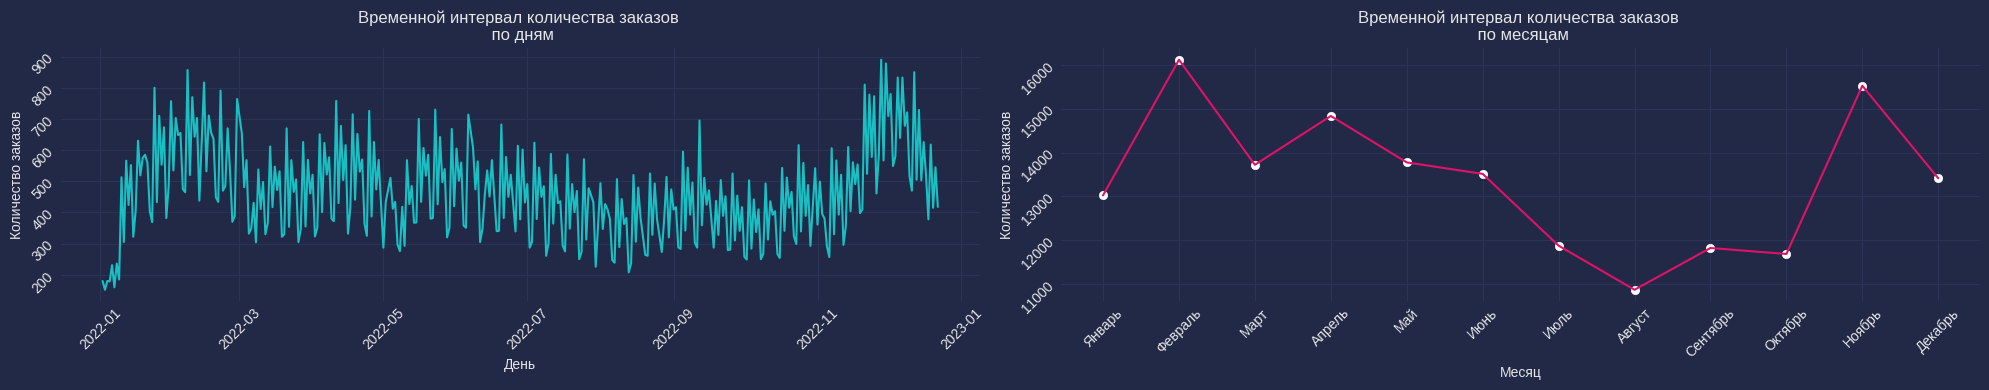

In [26]:
time_val = df.groupby('date', as_index=False)['ration'].count()# группировка количества заказов по дням
time_val_month = df.groupby(['month', 'month_str'], as_index=False)['ration'].count()# группировка количества заказов по месяцам

# Строим графики зависимости количества заказов от дня/месяца
#------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

days = sns.lineplot(x=time_val.date, y=time_val.ration, ax=axes[0])

months = sns.lineplot(x=time_val_month.month_str, y=time_val_month.ration, color='#e01268' ,ax=axes[1])
scater = sns.scatterplot(x=time_val_month.month_str, y=time_val_month.ration, ax=axes[1], color='#fff')

days.xaxis.set_tick_params(rotation=45)
days.yaxis.set_tick_params(rotation=45)
months.xaxis.set_tick_params(rotation=45)
months.yaxis.set_tick_params(rotation=45)

days.set(title='Временной интервал количества заказов \n по дням', xlabel='День', ylabel='Количество заказов')
months.set(title='Временной интервал количества заказов \n по месяцам', xlabel='Месяц', ylabel='Количество заказов')
fig.set_tight_layout(tight=True);

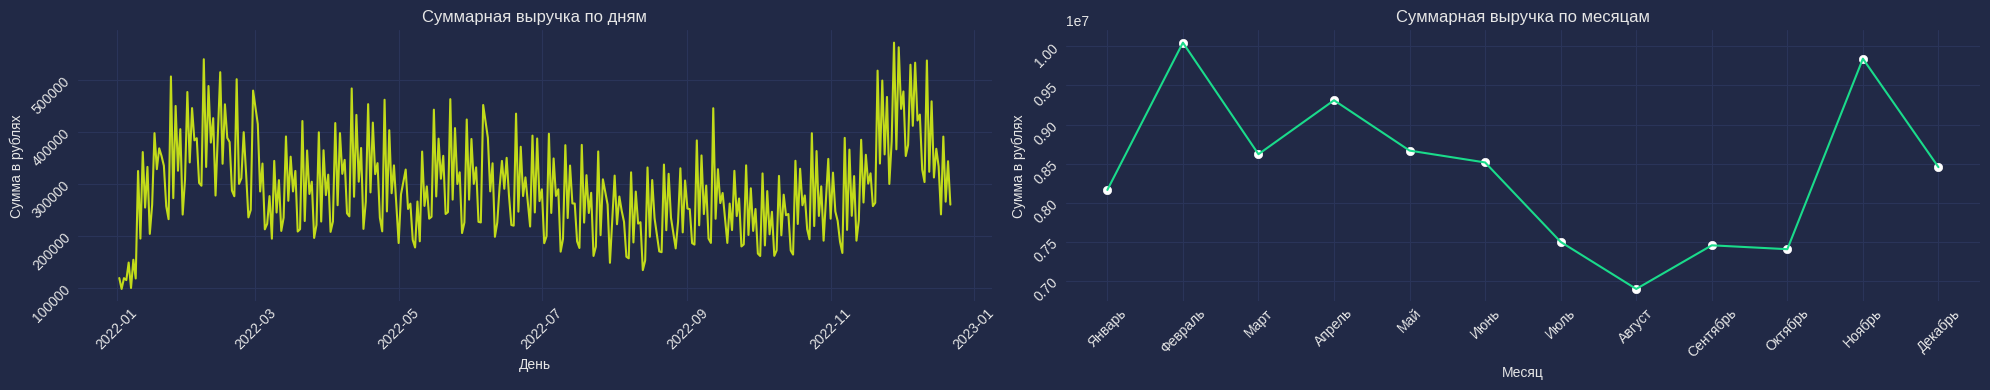

In [27]:
price_val = df.groupby('date', as_index=False)['price'].sum()# группировка суммарной выручки по дням
price_val_month = df.groupby(['month', 'month_str'], as_index=False)['price'].sum()# группировка суммарной выручки по месяцам

# Строим графики зависимости суммарной выручки от дня/месяца
#------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

days = sns.lineplot(x=price_val.date, y=price_val.price, color='#c2db1a', ax=axes[0])

months = sns.lineplot(x=price_val_month.month_str, y=price_val_month.price, color='#1adb8b' ,ax=axes[1])
scater = sns.scatterplot(x=price_val_month.month_str, y=price_val_month.price, ax=axes[1], color='#fff')

days.xaxis.set_tick_params(rotation=45)
days.yaxis.set_tick_params(rotation=45)
months.xaxis.set_tick_params(rotation=45)
months.yaxis.set_tick_params(rotation=45)

days.set(title='Суммарная выручка по дням', xlabel='День', ylabel='Сумма в рублях')
months.set(title='Суммарная выручка по месяцам', xlabel='Месяц', ylabel='Сумма в рублях')
fig.set_tight_layout(tight=True);

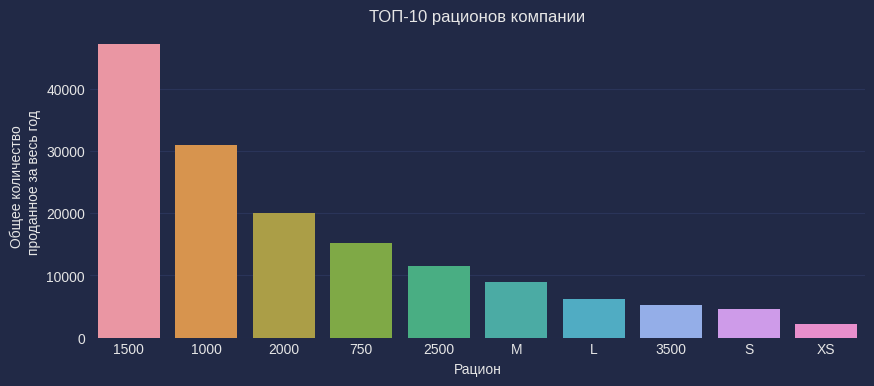

In [28]:
ration = df['ration'].value_counts().sort_values(ascending=False)[:10]
ration = pd.DataFrame({'ration': ration.index, 'count': ration.values})

fig = plt.figure(figsize=(10, 4))

bar = sns.barplot(x=ration['ration'], y=ration['count'])
bar.set(title='ТОП-10 рационов компании', xlabel='Рацион', ylabel='Общее количество \n проданное за весь год');

In [29]:
start = df['start'].value_counts().sort_values(ascending=False)[:5]
start = pd.DataFrame({'start': start.index, 'count': start.values})

/tmp/ipykernel_13028/3625466734.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = df['start'].value_counts().sort_values(ascending=False)[:5]


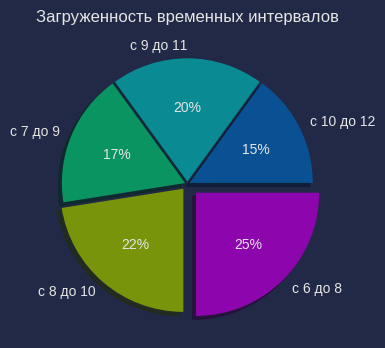

In [30]:
fig, ax = plt.subplots(figsize=(16, 4))
colors = ['#0a5194', '#0a8b94', '#0a9461', '#78940a', '#8c05ad']
labels = [f'с {str(elem)} до {str(elem + 2)}' for elem in start.start.values[::-1]]
explode = [0.02, 0.02, 0.02, 0.05, 0.1]

pie = plt.pie(
    x=start['start'], labels=labels, colors=colors,
    autopct = '%d%%', explode=explode, shadow=True
    )

ax.set(title='Загруженность временных интервалов');

In [31]:
def temp_group(deegre):
    if deegre < -15: return 'Заморозки'
    if 0 > deegre >= -15: return 'Холодно'
    if 10 > deegre >= 0: return 'Прохладно'
    if 20 > deegre >= 10: return 'Тепло'
    if deegre >= 20: return 'Жарко'

def get_season(month):
    if month in [12, 1, 2]: return 'Зима'
    if month in [3, 4, 5]: return 'Весна'
    if month in [6, 7, 8]: return 'Лето'
    if month in [9, 10, 11]: return 'Осень'

df_temp = df[['weather', 'ration', 'month']].sort_values(by='weather')
df_temp['weather_group'] = df_temp['weather'].apply(temp_group)
df_temp['season'] = df_temp['month'].apply(get_season)

temp_val = df_temp.groupby('weather_group')['ration'].count().sort_values()
season_val = df_temp.groupby('season')['ration'].count()

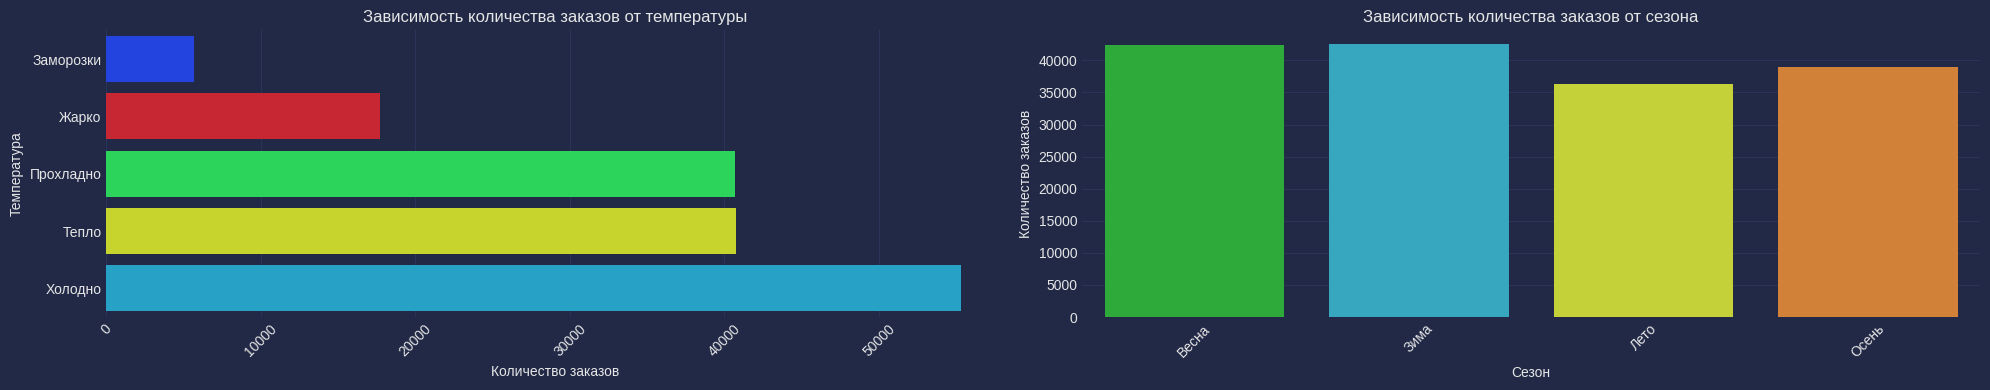

In [32]:
palette_temp = ['#052fff', '#e00d1c', '#11f050', '#ddf011', '#0dafe0']
palette_season= ['#19bf2a', '#20b5d6', '#daeb1e', '#eb811e']


fig, axes = plt.subplots(1, 2, figsize=(20, 4))

bar_temp = sns.barplot(
    x=temp_val.values, y=temp_val.index,
    palette=palette_temp, ax=axes[0]
    )
bar_season = sns.barplot(
    y=season_val.values, x=season_val.index,
    palette=palette_season, ax=axes[1]
    )

bar_temp.xaxis.set_tick_params(rotation=45)
bar_season.xaxis.set_tick_params(rotation=45)

bar_temp.set(
    title='Зависимость количества заказов от температуры',
    xlabel='Количество заказов', ylabel='Температура'
    )
bar_season.set(
    title='Зависимость количества заказов от сезона',
    xlabel='Сезон', ylabel='Количество заказов'
    )
fig.set_tight_layout(tight=True);

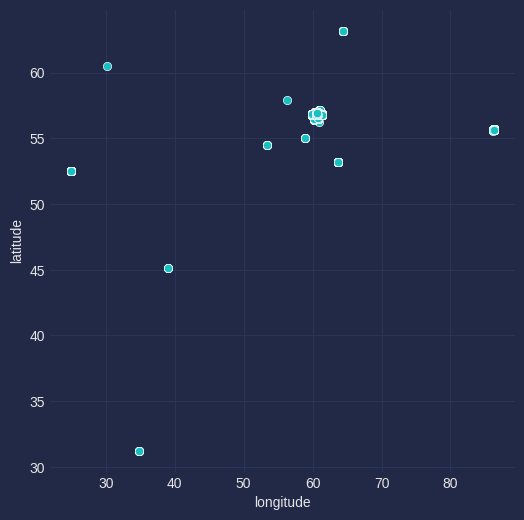

In [33]:
fig = plt.figure(figsize=(6, 6))
scater = sns.scatterplot(x=df['longitude'], y = df['latitude'])

___

In [34]:
def clean_iqr(df):
    
    def z_score(ser: pd.Series, step=1.5) -> int:
        first_q = ser.quantile(0.25)
        third_q = ser.quantile(0.75)
        iqr = third_q - first_q

        upper_bound = third_q + iqr * step
        lower_bound = first_q - iqr * step
        out = ser[(ser >= upper_bound) | (ser <= lower_bound)]
        
        return out.index

    # находим индексы выбросов
    res_let = z_score(df['latitude'])
    res_long = z_score(df['longitude'])
    res_full = set(res_let).intersection(set(res_long))
    
    print(f'Нашлось {len(res_full)} выбросов')

    # находим наш датасэт от выбросов
    clean_ind = sorted(list(set(df.index).difference(res_full)))

    return df.iloc[clean_ind]

In [35]:
def clean_z_score(df: pd.DataFrame, step=1) -> pd.DataFrame:
    """ Функция очищает датасэт от геолокационных выбросов 

    Args:
        df (pd.DataFrame): Датасэт с выбросами

    Returns:
        pd.DataFrame: Чистый датасэт
    """

    # функция возращает индексы которые относятся к выбросам
    def z_score(ser: pd.Series) -> int:
        u = ser.mean()
        sigma = ser.std()
        upper_bound = u + step * sigma
        lower_bound = u - step * sigma
        out = ser[(ser >= upper_bound) | (ser <= lower_bound)]
        return out.index

    # находим индексы выбросов
    res_let = z_score(df['latitude'])
    res_long = z_score(df['longitude'])
    res_full = set(res_let).intersection(set(res_long))

    print(f'Нашлось {len(res_full)} выбросов')
    
    # находим наш датасэт от выбросов
    clean_ind = sorted(list(set(df.index).difference(res_full)))

    return df.iloc[clean_ind]

In [36]:
z_df = clean_z_score(df, step=1)
iqr_df = clean_iqr(df)

Нашлось 475 выбросов
Нашлось 3746 выбросов


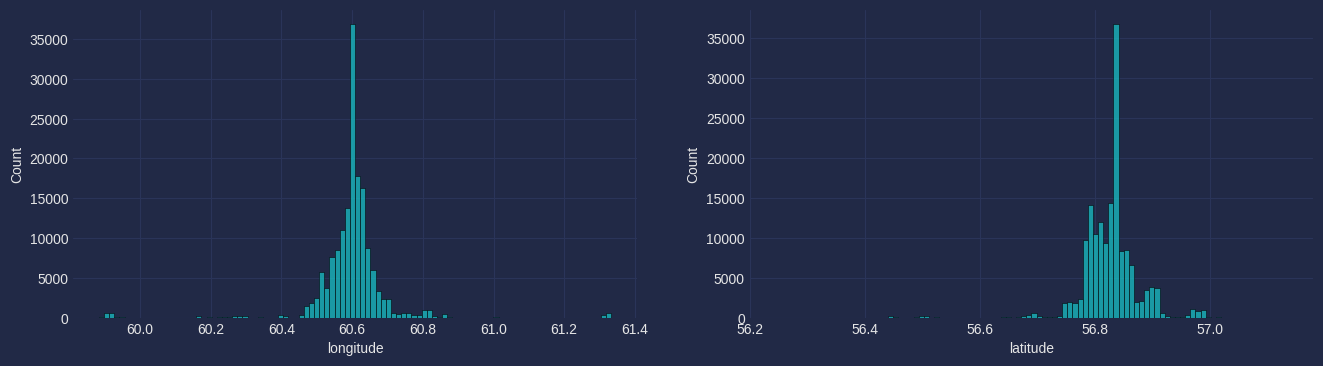

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(x=z_df['longitude'], bins=100, ax=axes[0])
sns.histplot(x=z_df['latitude'], bins=100, ax=axes[1]);

In [38]:
df['location'].value_counts()[:10].sum()

27060

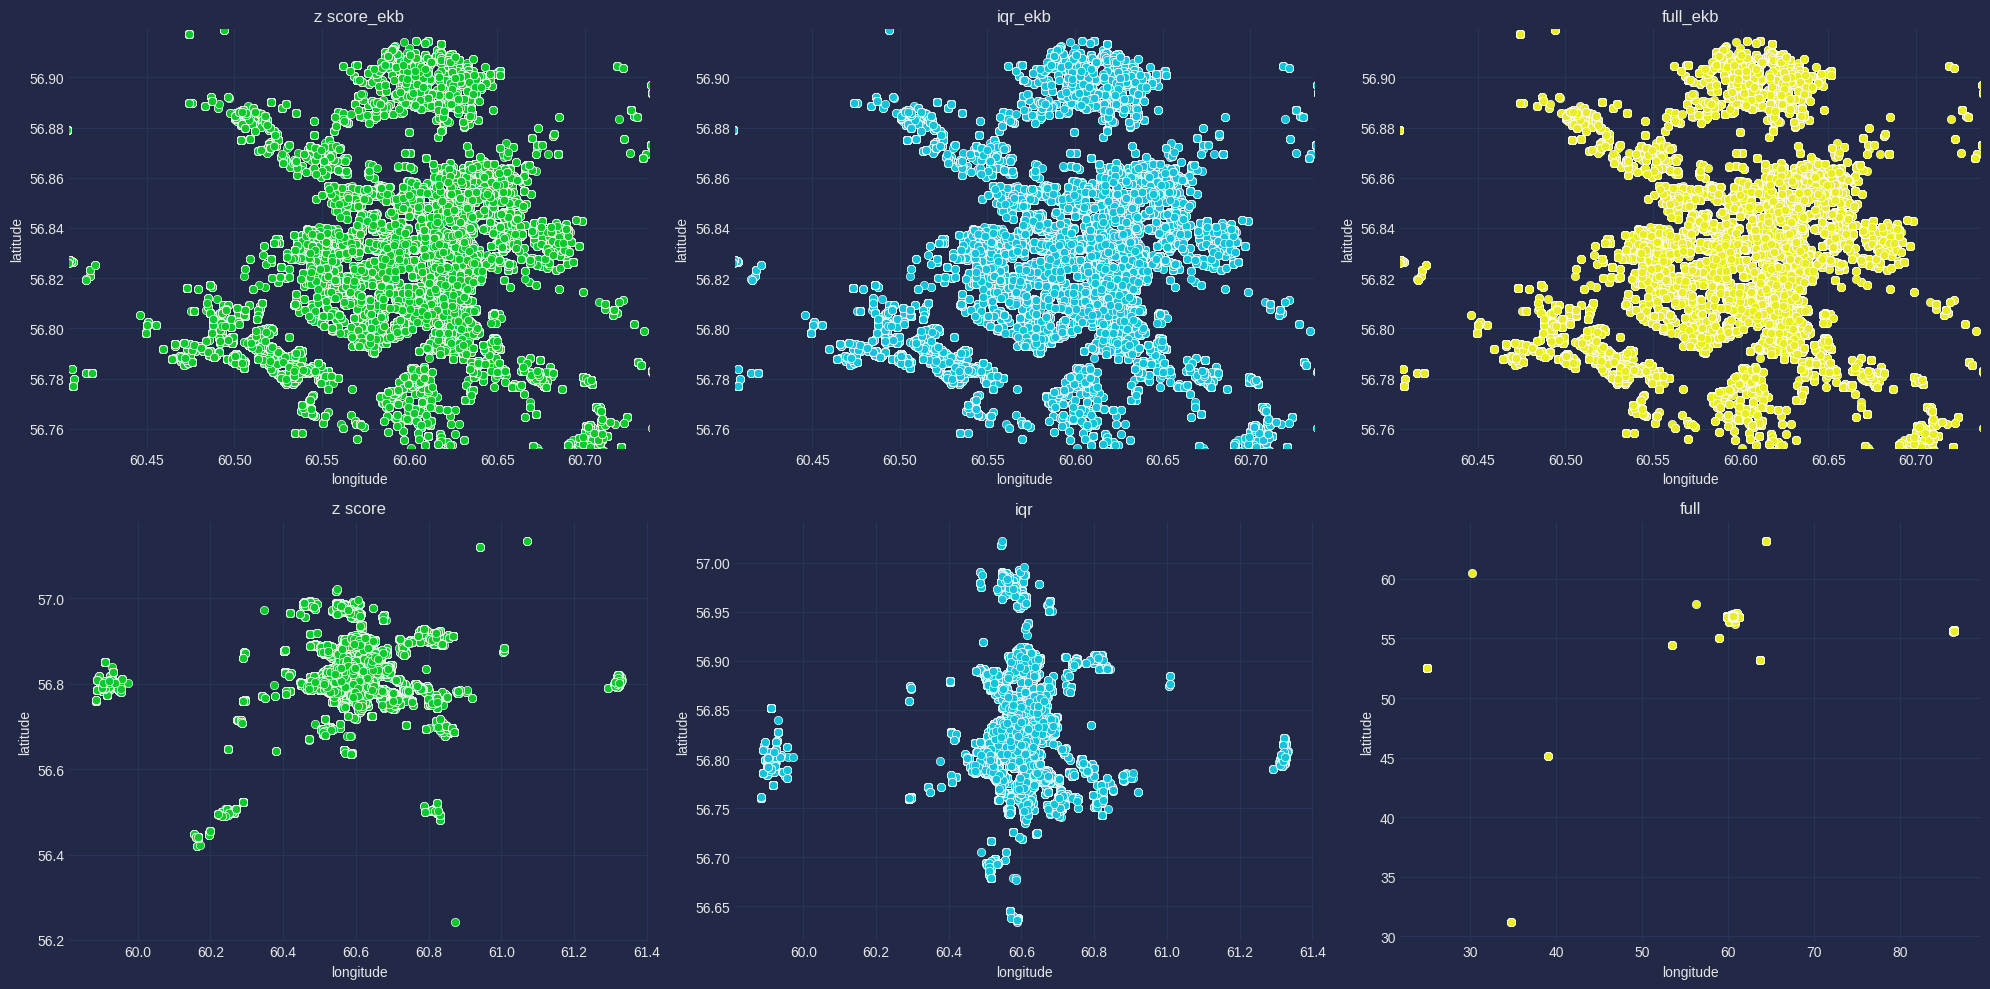

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

scater_z_ekb = sns.scatterplot(x=z_df['longitude'], y=z_df['latitude'], color='#0cc92c', ax=axes[0][0])
scater_z_ekb.set_ylim(56.752366, 56.919087)
scater_z_ekb.set_xlim(60.405890, 60.736505)

scater_iqr_ekb = sns.scatterplot(x=iqr_df['longitude'], y=iqr_df['latitude'], color='#12c4db', ax=axes[0][1])
scater_iqr_ekb.set_ylim(56.752366, 56.919087)
scater_iqr_ekb.set_xlim(60.405890, 60.736505)


scater_full_ekb = sns.scatterplot(x=df['longitude'], y=df['latitude'],color='#eaed24', ax=axes[0][2])
scater_full_ekb.set_ylim(56.752366, 56.919087)
scater_full_ekb.set_xlim(60.405890, 60.736505)

scater_z_ekb.set(title='z score_ekb')
scater_iqr_ekb.set(title='iqr_ekb')
scater_full_ekb.set(title='full_ekb')


scater_z = sns.scatterplot(x=z_df['longitude'], y=z_df['latitude'], color='#0cc92c', ax=axes[1][0])
scater_iqr = sns.scatterplot(x=iqr_df['longitude'], y=iqr_df['latitude'], color='#12c4db', ax=axes[1][1])
scater_full = sns.scatterplot(x=df['longitude'], y=df['latitude'], color='#eaed24', ax=axes[1][2])

scater_z.set(title='z score')
scater_iqr.set(title='iqr')
scater_full.set(title='full')
plt.tight_layout();

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

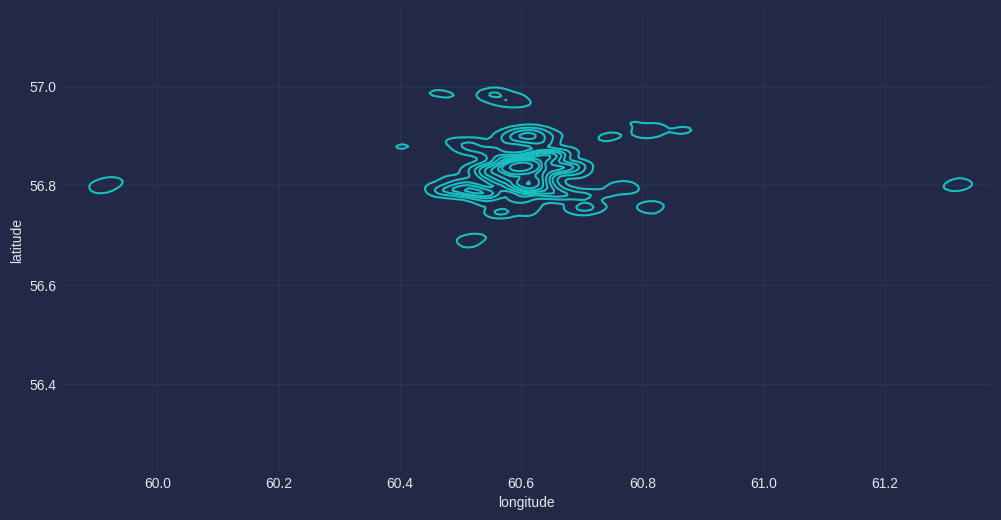

In [40]:
fig = plt.figure(figsize=(12, 6))
sns.kdeplot(x=z_df['longitude'], y=z_df['latitude'])

In [85]:
xlim = [60.405890, 60.736505]
ylim = [56.752366, 56.919087]
print(len(df))
print(f" full: {len(df[(df['latitude'] >= ylim[0]) & (df['latitude'] <= ylim[1]) & (df['longitude'] >= xlim[0]) & (df['longitude'] <= xlim[1])])}")
print(f" iqr_df: {len(iqr_df[(iqr_df['latitude'] >= ylim[0]) & (iqr_df['latitude'] <= ylim[1]) & (iqr_df['longitude'] >= xlim[0]) & (iqr_df['longitude'] <= xlim[1])])}")
print(f" z_df: {len(z_df[(z_df['latitude'] >= ylim[0]) & (z_df['latitude'] <= ylim[1]) & (z_df['longitude'] >= xlim[0]) & (z_df['longitude'] <= xlim[1])])}")

160180
 full: 144953
 iqr_df: 144917
 z_df: 144953


In [75]:
print(f'df lenght: {len(df)}')
print(f'z_df lenght: {len(z_df)}')
print(f'iqr_df lenght: {len(iqr_df)}')

df lenght: 160180
z_df lenght: 159705
iqr_df lenght: 156434


___

10 месяц   30
4 месяц   30
5 месяц   3
6 месяц   25, 7
7 месяц   28
8 месяц   19
9 месяц   17

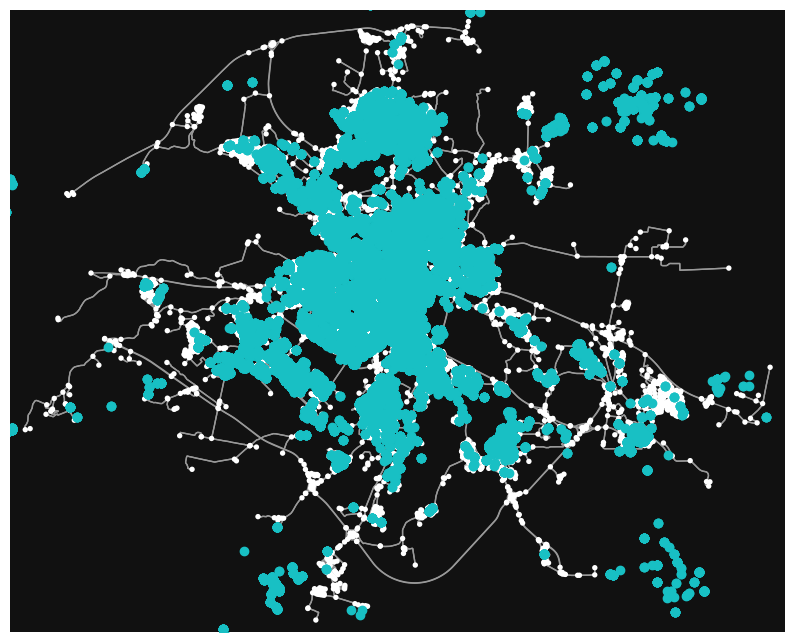

In [101]:
loc_list = df['location'].to_list()
latitude_list = [elem[0] for elem in loc_list]
longitude_list = [elem[1] for elem in loc_list] 

map = ox.graph_from_place('Ekaterinburg, Russia', network_type='drive')

fig, ax = ox.plot_graph(map, figsize=(10, 10), close=False, show=False)

ax.scatter(longitude_list, latitude_list);